In [1]:
import os
LINKEDIN_CLIENT_ID = os.getenv("LINKEDIN_CLIENT_ID")
LINKEDIN_CLIENT_SECRET = os.getenv("LINKEDIN_CLIENT_SECRET")

In [38]:
import os
from crewai import Agent, Task, Crew, Process
from crewai_tools import SerperDevTool
from openai import OpenAI
from crewai.tools import BaseTool
from langchain_community.utilities.dalle_image_generator import DallEAPIWrapper
import dotenv
from datetime import datetime
import requests
import base64
from typing import Optional, ClassVar
from typing import Optional, ClassVar
from pydantic import Field
from typing import Optional
from pydantic import Field, PrivateAttr
from openai import OpenAI


class ImageGenerationTool(BaseTool):
    name: str = Field(default="Image Generator")
    description: str = Field(default="Generates and saves professional background images for social media content")
    output_dir: str = Field(default="img")
    
    # Use PrivateAttr for non-serializable instances
    _client: OpenAI = PrivateAttr()

    def __init__(self, output_dir: str = "img", **data):
        super().__init__(**data)
        self._client = OpenAI()
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    def _run(self, prompt: str, filename: Optional[str] = None) -> str:
        """
        Generate and save an image based on the prompt
        Args:
            prompt (str): Description of the image to generate
            filename (str, optional): Custom filename for the image
        Returns:
            str: Path to the saved image
        """
        try:
            response = self._client.images.generate(
                model="dall-e-3",
                prompt=prompt,
                size="1024x1024",
                quality="standard",
                n=1,
            )
            
            image_url = response.data[0].url
            
            if filename is None:
                timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                filename = f"carousel_{timestamp}.png"
            
            response = requests.get(image_url)
            if response.status_code == 200:
                filepath = os.path.join(self.output_dir, filename)
                with open(filepath, "wb") as f:
                    f.write(response.content)
                return filepath
            return "Failed to download image"
        except Exception as e:
            return f"Error generating image: {str(e)}"

image_designer_agent = Agent(
    role='Image Designer',
    goal='Create subtle, text-friendly background images for social media content',
    backstory=(
        "An expert in creating minimalist, professional background designs "
        "that enhance readability and maintain visual hierarchy. Specializes in "
        "subtle patterns, gradients, and abstract compositions that complement "
        "text overlays without competing for attention."
    ),
    verbose=True,
    memory=True,
    tools=[ImageGenerationTool()]
)

image_design_task = Task(
    description=(
        "Create background images for a {social_platform} carousel post about {topic} "
        "targeting {expertise_level} audience. Generate one image per slide."
        "\n\nImage requirements:"
        "\n- Extremely subtle and minimal background designs"
        "\n- NO human figures, hands, or detailed objects"
        "\n- Focus on abstract patterns, gentle gradients, or simple geometric shapes"
        "\n- Ensure high text readability with clean, uncluttered compositions"
        "\n- Use muted colors that won't compete with text overlays"
        "\n- Color scheme based on complexity level:"
        "\n  * Beginner: Soft, warm gradients (blues, warm grays)"
        "\n  * Intermediate: Professional, neutral tones (navy, slate, subtle gold)"
        "\n  * Advanced: Rich, deep colors (dark blues, burgundy, charcoal)"
        "\n\nAdditional guidelines:"
        "\n- Maintain 30% or less visual complexity"
        "\n- Ensure patterns are subtle enough to read white or black text clearly"
        "\n- Avoid any text or symbols in the images"
    ),
    expected_output="A list of paths to generated images, one for each carousel slide.",
    agent=image_designer_agent
)
PREFERRED_DOMAINS = {
    "trading": [
        "tradestation.com",
        "cmegroup.com",
        "theice.com",
        "rjofutures.rjobrien.com"
        "bloomberg.com",
        "reuters.com"
    ],
    "crypto": [
        "coindesk.com",
        "cointelegraph.com",
        "binance.com",
        "kraken.com"
    ]
}


research_agent = Agent(
    role='Researcher',
    goal='Gather detailed and relevant information about {topic}.',
    backstory=(
        "A skilled and inquisitive researcher, adept at diving deep into topics "
        "and pulling out critical insights that are accurate and comprehensive. "
        "Prioritizes authoritative sources and cross-references information."
    ),
    verbose=True,
    memory=True,
    tools=[
        SerperDevTool(
            search_params={
                "site": " OR ".join(PREFERRED_DOMAINS.get("trading", [])),
                "num": 5
            }
        ),
        SerperDevTool(
            search_params={
                "num": 5,
                "exclude": "pinterest.com,facebook.com,instagram.com"
            }
        )
    ]
)

writer_agent = Agent(
    role='Writer',
    goal='Create content about {topic} tailored for {expertise_level} audience on {social_platform}.',
    backstory=(
        "An expert content creator who specializes in adapting complex topics for different "
        "audiences and social media platforms. Skilled at creating engaging content that "
        "matches each platform's unique style and requirements."
    ),
    verbose=True,
    memory=True,
)


research_task = Task(
    description=(
        "Conduct thorough research on the topic {topic}. Focus on collecting key points, "
        "relevant statistics, and critical insights to form a strong foundation for the report."
    ),
    expected_output="A comprehensive list of data points and insights about {topic}.",
    agent=research_agent
)


writing_task = Task(
    description=(
        "Using the research findings, create content about {topic} specifically for {social_platform}. "
        "The content should be appropriate for a {expertise_level} audience. "
        "\n\nFormat requirements:"
        "\n- If platform is 'tiktok': Create 3-5 short script segments (60 seconds each) with hooks and hashtags"
        "\n- If platform is 'twitter': Create a thread of 5-7 tweets"
        "\n\nLinkedIn Post Format Requirements:"
        "\n- NO asterisks or markdown formatting"
        "\n- For emphasis, use CAPS or simply regular text"
        "\n\nExample of CORRECT formatting:"
        "\nWant to elevate your gold futures trading game? 🌟"
        "\n\n"
        "\nHere's your essential guide to navigating this dynamic market."
        "\n\n"
        "\n📊 Market Metrics That Matter:"
        "\n• Average gold price: USD 1,940.54/oz"
        "\n• Daily trading volume: 27 million ounces"
        "\n• Market value: USD 276.04 billion"
        "\n\n"
        "\n🔍 Key Trends:"
        "\n1. Price Expectations: Projected to reach USD 2,500/oz"
        "\n2. Growing Demand: Steady increase in global markets"
        "\n\n"
        "\nReady to learn more? Let's connect! 👇"
        "\n\n"
        "\n#GoldTrading #FuturesTrading #FinancialEducation"
        "\n\nNOTE: Do not use any asterisks (*) or other markdown formatting. "
        "Use natural emphasis through capitalization or simple text."
        "\n- If platform is 'instagram': "
        "\n  * Create carousel slides (no markdown)"
        "\n  * One main point per slide"
        "\n  * Emojis for visual appeal"
        "\n  * Hashtags in a comment block at the end"
        "\n  * Short, punchy sentences"
        "\n  * Use line breaks for readability"
        "\n  * No markdown formatting symbols"
        "\n- If platform is 'instagram': Create a carousel post with 5-7 slides, including a hook slide, "
        "key points slides, and a call-to-action slide. Include relevant hashtags"
        "\n\nAudience expertise requirements:"
        "\n- For 'beginner': "
        "\n  * Explain every technical concept in detail"
        "\n  * Use simple analogies and real-world comparisons"
        "\n  * Break down complex terms into simpler components"
        "\n  * Include basic educational content about market fundamentals"
        "\n  * Focus on building foundational knowledge"
        "\n- For 'intermediate': "
        "\n  * Assume basic market knowledge and terminology"
        "\n  * Focus on explaining advanced concepts and strategies"
        "\n  * Include some technical analysis but with explanations"
        "\n  * Connect concepts to practical trading scenarios"
        "\n  * Provide deeper insights into market mechanics"
        "\n- For 'advanced': "
        "\n  * Pure technical analysis and advanced market insights"
        "\n  * Focus on actionable data points and market signals"
        "\n  * Include specific trade setups and market conditions"
        "\n  * Discuss complex correlations and market dynamics"
        "\n  * Skip basic explanations entirely"
        "\n  * Use industry jargon freely"
        "\n\nAfter creating the content, save it as a draft on LinkedIn "
        "for human review before publishing."
    ),
    expected_output="Platform-native content with NO markdown formatting symbols.",
    agent=writer_agent,
    async_execution=False
)

crew = Crew(
    agents=[research_agent, writer_agent], #image_designer_agent],
    tasks=[research_task, writing_task],# image_design_task],
    process=Process.sequential
)

result = crew.kickoff(inputs={
    "topic": "trading S&P 500 futures",
    "expertise_level": "advanced",
    "social_platform": "linkedin"
})

print("Content:", result)

2024-12-09 15:43:23,781 - 8117181504 - __init__.py-__init__:537 - WARNING: Overriding of current TracerProvider is not allowed


# Agent: Researcher
## Task: Conduct thorough research on the topic trading S&P 500 futures. Focus on collecting key points, relevant statistics, and critical insights to form a strong foundation for the report.


# Agent: Researcher
## Thought: I need to gather comprehensive information regarding trading S&P 500 futures, including key points, statistics, and insights.
## Using tool: Search the internet
## Tool Input: 
"{\"search_query\": \"trading S&P 500 futures insights statistics key points\"}"
## Tool Output: 

Search results: Title: How Do S&P 500 Futures Work? - Investopedia
Link: https://www.investopedia.com/ask/answers/042315/how-do-sp-500-futures-work.asp
Snippet: S&P 500 futures are a type of derivative contract that provides buyers with an investment price based on the expectation of the S&P 500 Index's future value.
---
Title: S&P 500® Futures: A Look at the Basics - Charles Schwab
Link: https://www.schwab.com/learn/story/sp-500-futures-look-basics
Snippet: S&P 500 index f

Current working directory: /Users/kerimtricic/DualSharks/StockPilot/social_media



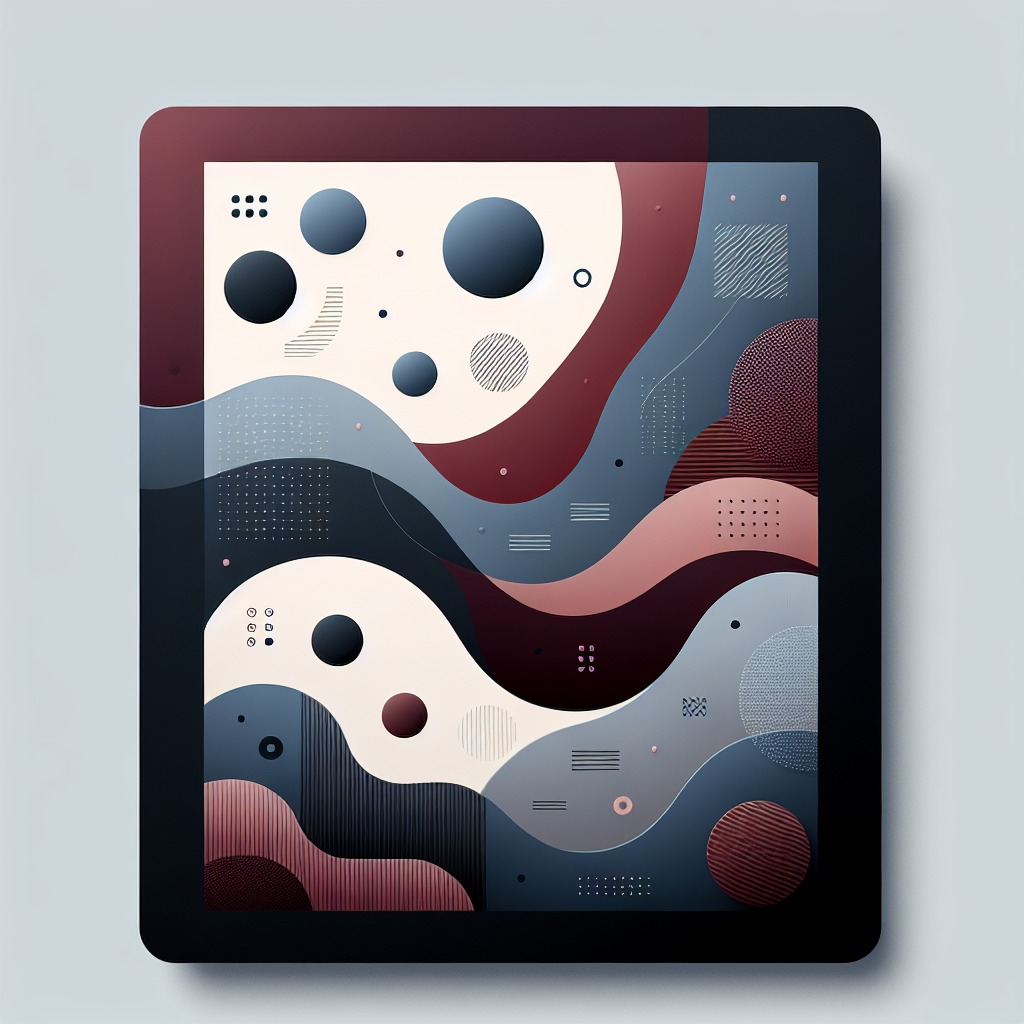

'linkedin_preview.png'

In [39]:
import os
from pathlib import Path
from jinja2 import Template
from IPython.display import HTML, display
from datetime import datetime
from typing import List
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import tempfile
import time

class LinkedInPreviewGenerator:
    def __init__(self):
        self.template = Template('''
        <div style="max-width: 552px; margin: 20px auto; font-family: -apple-system,system-ui,BlinkMacSystemFont,'Segoe UI',Roboto,'Helvetica Neue',Arial,sans-serif; border: 1px solid #e0e0e0; border-radius: 8px; background: white; padding: 12px;">
            <!-- Profile Header -->
            <div style="display: flex; align-items: center; margin-bottom: 12px;">
                <div style="width: 48px; height: 48px; border-radius: 50%; background: #0a66c2; color: white; display: flex; align-items: center; justify-content: center; font-weight: bold;">DS</div>
                <div style="margin-left: 8px;">
                    <div style="font-weight: 600; color: rgba(0,0,0,0.9);">DualSharks</div>
                    <div style="font-size: 14px; color: rgba(0,0,0,0.6);">{{ timestamp }}</div>
                </div>
            </div>
            
            <!-- Post Content -->
            <div style="color: rgba(0,0,0,0.9); font-size: 14px; margin: 12px 0; white-space: pre-wrap;">{{ text }}</div>
            
            <!-- Images -->
            {% if images %}
            <div style="margin: 12px -12px;">
                {% if images|length == 1 %}
                <img src="{{ images[0] }}" style="width: 100%; max-height: 400px; object-fit: cover;">
                {% else %}
                <div style="display: grid; grid-template-columns: repeat({{ min(images|length, 2) }}, 1fr); gap: 2px;">
                    {% for image in images %}
                    <img src="{{ image }}" style="width: 100%; height: 250px; object-fit: cover;">
                    {% endfor %}
                </div>
                {% endif %}
            </div>
            {% endif %}
            
            <!-- Interaction Buttons -->
            <div style="display: flex; justify-content: space-around; margin-top: 12px; padding-top: 12px; border-top: 1px solid #e0e0e0;">
                <div style="color: rgba(0,0,0,0.6); font-size: 14px;">👍 Like</div>
                <div style="color: rgba(0,0,0,0.6); font-size: 14px;">💬 Comment</div>
                <div style="color: rgba(0,0,0,0.6); font-size: 14px;">↗️ Share</div>
            </div>
        </div>
        ''')

    def _get_image_base64(self, image_path: str) -> str:
        """Convert image to base64 string"""
        with open(image_path, 'rb') as img_file:
            return base64.b64encode(img_file.read()).decode('utf-8')

    def generate_preview(self, text: str, image_paths: List[str] = None) -> None:
        images = []
        if image_paths:
            for path in image_paths:
                if os.path.exists(path):
                    # Convert to base64 and create data URL
                    img_type = path.split('.')[-1].lower()
                    b64_img = self._get_image_base64(path)
                    images.append(f"data:image/{img_type};base64,{b64_img}")

        # Generate timestamp
        timestamp = datetime.now().strftime("%b %d, %Y")

        # Render the preview
        html = self.template.render(
            text=text,
            images=images,
            timestamp=timestamp
        )
        
        display(HTML(html))
    
    def save_preview_as_png(self, text: str, image_paths: List[str], output_path: str) -> str:
        """
        Save the LinkedIn preview as a PNG file
        Args:
            text: The post content
            image_paths: List of paths to images to include
            output_path: Where to save the PNG file
        Returns:
            str: Path to the saved PNG file
        """
        # Generate the HTML preview
        images = []
        if image_paths:
            for path in image_paths:
                if os.path.exists(path):
                    b64_img = self._get_image_base64(path)
                    img_type = path.split('.')[-1].lower()
                    images.append(f"data:image/{img_type};base64,{b64_img}")

        timestamp = datetime.now().strftime("%b %d, %Y")
        html = self.template.render(
            text=text,
            images=images,
            timestamp=timestamp
        )

        # Create a temporary HTML file
        with tempfile.NamedTemporaryFile('w', suffix='.html', delete=False) as f:
            f.write(f"""
                <html>
                <body style="background-color: #f3f2ef; padding: 20px;">
                    {html}
                </body>
                </html>
            """)
            temp_path = f.name

        try:
            # Setup Chrome options
            chrome_options = Options()
            chrome_options.add_argument("--headless")  # Run in headless mode
            chrome_options.add_argument("--window-size=800,1000")
            chrome_options.add_argument("--hide-scrollbars")

            # Create driver and capture screenshot
            driver = webdriver.Chrome(options=chrome_options)
            driver.get(f"file://{temp_path}")
            time.sleep(1)  # Wait for any images to load
            
            # Find the preview div and capture it
            preview = driver.find_element("css selector", "div[style*='max-width: 552px']")
            preview.screenshot(output_path)
            
            driver.quit()
            return output_path

        finally:
            # Cleanup temporary file
            os.unlink(temp_path)

# Example usage:
preview_generator = LinkedInPreviewGenerator()

# Test with your content
sample_text = result

test_image_paths = ["./img/slide2_background.png"]  # Replace with your actual image path
print(f"Current working directory: {os.getcwd()}")  # Debug print
preview_generator.generate_preview(
    text=sample_text,
    image_paths=test_image_paths
    
)
preview_generator.save_preview_as_png(
    text=sample_text,
    image_paths=test_image_paths,
    output_path="linkedin_preview.png"
)